In [147]:
import tensorflow as tf
import time

import numpy as np # linear algebra
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [148]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.cifar10.load_data()

In [149]:
label_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [150]:
x_train=x_train.transpose(0, 2, 3, 1)
x_test=x_test.transpose(0, 2, 3, 1)

In [151]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [152]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [153]:
# normalize
x_train = normalize(x_train)
x_test = normalize(x_test)


y_train=one_hot_encode(y_train)
y_test=one_hot_encode(y_test)

In [154]:
training_epochs = 150
batch_size = 128
learning_rate = 0.001
display_step=10
n_hidden=200

input_size=3072
output_size=10

In [155]:
def layer(x, weight_shape, bias_shape, activation):
    
    """
    Defines the network layers
    input:
        - x: input vector of the layer
        - weight_shape: shape the the weight maxtrix
        - bias_shape: shape of the bias vector
    output:
        - output vector of the layer after the matrix multiplication and non linear transformation
    """
    
    # comes from the study by He et al. for ReLU layers
    w_std = (2.0/weight_shape[0])**0.5
    #print(weight_shape[0])
    #w_std = 0.5;

    #initialization of the weights
    #you can try either
    w_0 = tf.random_normal_initializer(stddev=w_std)
    #w_0 = tf.random_uniform_initializer(minval=-1,maxval=1)

    b_0 = tf.constant_initializer(value=0)
    
    W = tf.get_variable("W", weight_shape, initializer=w_0)
    b = tf.get_variable("b", bias_shape,   initializer=b_0)
    
    print('Weight Matrix:', W)
    print('Bias Vector:', b)
    
    
    if activation=='relu':
        return tf.nn.relu(tf.matmul(x, W) + b)
    elif activation== 'linear':
        return tf.matmul(x, W) + b
    elif activation=='tanh':
        return tf.nn.tanh(tf.matmul(x, W) + b)
    elif activation=='sigmoid':
        return tf.nn.sigmoid(tf.matmul(x, W) + b)
    elif activation=='leakyrelu':
        return tf.nn.leaky_relu(tf.matmul(x, W) + b)



In [156]:
def inference(x, desired_layer=4):
    """
    define the whole network (2 hidden layers + output layers)
    input:
        - a batch of pictures 
        (input shape = (batch_size*image_size))
    output:
        - a batch vector corresponding to the logits predicted by the network
        (output shape = (batch_size*output_size)) 
    """
    
    hidden={}
    #activation=['sigmoid', 'sigmoid', 'reLU', 'tanh', 'leakyrelu']
    
    with tf.variable_scope('hidden_layer_1'):
            hidden[1] = layer(x, [input_size, n_hidden], [n_hidden], 'leakyrelu')

    range_=np.arange(2, desired_layer+1, 1)
    
    for i in range_:
        name_='hidden_layer_'+str(i)
        
        with tf.variable_scope(name_):
           
            hidden[i] = layer(hidden[i-1], [n_hidden, n_hidden], [n_hidden], 'leakyrelu')
            #print([input_size, n_hidden_1])
     
    
    with tf.variable_scope("output"):
        output = layer(hidden[desired_layer], [n_hidden, output_size], [output_size], 'leakyrelu')
        #print([n_hidden_2, output_size])

    return output

In [157]:
def loss_2(output, y):
    """
    Computes softmax cross entropy between logits and labels and then the loss 
    
    intput:
        - output: the output of the inference function 
        - y: true value of the sample batch
         
        the two have the same shape (batch_size * num_of_classes)
    output:
        - loss: loss of the corresponding batch (scalar tensor)
    
    """

    #mean square error
    #loss = tf.reduce_mean(tf.reduce_sum(tf.square(y-output)))
    
    #Computes softmax cross entropy between logits and labels.
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y)
    loss = tf.reduce_mean(xentropy)

    return loss

In [158]:
def training(cost, global_step):
    """
    defines the necessary elements to train the network
    
    intput:
        - cost: the cost is the loss of the corresponding batch
        - global_step: number of batch seen so far, it is incremented by one 
        each time the .minimize() function is called
    """
    
    tf.summary.scalar("cost", cost)
    
    # tf.train.RMSPropOptimizer
    # will use different optimization routines 
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    train_op = optimizer.minimize(cost, global_step=global_step)
    
    return train_op

In [159]:
def evaluate(output, y):
    """
    evaluates the accuracy on the validation set 
    input:
        -output: prediction vector of the network for the validation set
        -y: true value for the validation set
    output:
        - accuracy: accuracy on the validation set (scalar between 0 and 1)
    """
    #correct prediction is a binary vector which equals one when the output and y match
    #otherwise the vector equals 0
    #tf.cast: change the type of a tensor into another one
    #then, by taking the mean of the tensor, we directly have the average score, so the accuracy
    
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    tf.summary.scalar("validation_error", (1.0 - accuracy))

    return accuracy

In [160]:
x_train2=x_train.reshape(50000, 32*3*32)
x_test2=x_test.reshape(10000, 32*3*32)

In [161]:
x_train, x_validation, y_train, y_validation=train_test_split(x_train2, y_train, test_size=0.12, random_state=42)

In [162]:
x_train2.shape, x_test2.shape

((50000, 3072), (10000, 3072))

In [165]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_1/W:0' shape=(3072, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_1/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_2/W:0' shape=(200, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_2/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_3/W:0' shape=(200, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_3/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_4/W:0' shape=(200, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_4/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_5/W:0' shape=(200, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_5/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_6/W:0

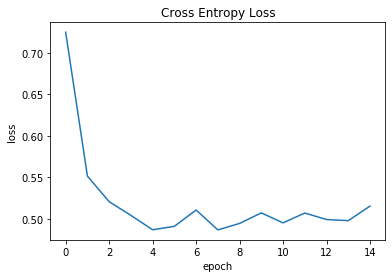

In [167]:
if __name__ == '__main__':
    
    start_time = time.time()
    #please, make sure you changed for your own path 
    log_files_path = '/Users/Renaissance/Desktop/'

    desired_layer=6
    
    with tf.Graph().as_default():
        
        with tf.variable_scope("multi_layer"):
            #neural network definition 
            
            #the input variables are first define as placeholder 
            # a placeholder is a variable/data which will be assigned later 
            # image vector & label
            x = tf.placeholder("float", [None, input_size])   # CIFAR data image of shape 3072
            y = tf.placeholder("float", [None, output_size])  # 0-9 digits recognition

            #the network is defined using the inference function defined above in the code
            output = inference(x, desired_layer)

            cost = loss_2(output, y)
            
            #initialize the value of the global_step variable 
            # recall: it is incremented by one each time the .minimise() is called
            global_step = tf.Variable(0, name='global_step', trainable=False)
            
            train_op = training(cost, global_step)
            #train_op = training(cost, global_step=None)
            
            #evaluate the accuracy of the network (done on a validation set)
            eval_op = evaluate(output, y)

            summary_op = tf.summary.merge_all()
    
            #save and restore variables to and from checkpoints.
            saver = tf.train.Saver()
    
            #defines a session
            sess = tf.Session()
            
            # summary writer
            #https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter
            #
            summary_writer = tf.summary.FileWriter(log_files_path+'multi_layer/', sess.graph)
        
            #initialization of all the variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
        
            #will work with this later
            #saver.restore(sess, log_files_path+'multi_layer/model-checkpoint-66000')
            
            loss_trace = []

            # Training cycle
            for epoch in range(training_epochs):

                avg_cost = 0.
                total_batch = int(x_train.shape[0]/batch_size)
            
                # Loop over all batches
                for i in range(total_batch):

                    minibatch_x, minibatch_y = next_batch(batch_size, x_train, y_train)
                    
                    # Fit training using batch data
                    #the training is done using the training dataset
                    sess.run(train_op, feed_dict={x: minibatch_x, y: minibatch_y})
                    
                    # Compute average loss
                    avg_cost += sess.run(cost, feed_dict={x: minibatch_x, y: minibatch_y})/total_batch
                    
                # Display logs per epoch step
                if epoch % display_step == 0:
                    
                    #the accuracy is evaluated using the validation dataset
                    accuracy = sess.run(eval_op, feed_dict={x: x_validation, y: y_validation})
                    loss_trace.append(1-accuracy)    
                    print("Epoch:", '%03d' % epoch, "cost function=", "{:0.7f}".format(avg_cost), " Validation Error:", (1.0 - accuracy))
                    summary_str = sess.run(summary_op, feed_dict={x: minibatch_x, y: minibatch_y})
                    summary_writer.add_summary(summary_str, sess.run(global_step))
                        
                    #save to use later
                    #https://www.tensorflow.org/api_docs/python/tf/train/Saver
                    #saver.save(sess, log_files_path+'model-checkpoint', global_step=global_step)
                    saver.save(sess, log_files_path + 'multi_layer/model-checkpoint', global_step=global_step)
                        
            print("Optimization Finished!")
            #accuracy evaluated with the whole test dataset
            accuracy = sess.run(eval_op, feed_dict={x: x_test2, y: y_test})
            print("Test Accuracy:", accuracy)
                    
            elapsed_time = time.time() - start_time
            print('Execution time (seconds) was %0.3f' % elapsed_time)
            
            # Visualization of the results
            # loss function
            plt.plot(loss_trace)
            plt.title('Cross Entropy Loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()

In [139]:
if __name__ == '__main__':
    
    start_time = time.time()
    #please, make sure you changed for your own path 
    log_files_path = '/Users/Renaissance/Desktop/'

    desired_layer=4
    
    with tf.Graph().as_default():
        
        with tf.variable_scope("multi_layer"):
            #neural network definition 
            
            #the input variables are first define as placeholder 
            # a placeholder is a variable/data which will be assigned later 
            # image vector & label
            x = tf.placeholder("float", [None, input_size])   # CIFAR data image of shape 3072
            y = tf.placeholder("float", [None, output_size])  # 0-9 digits recognition

            #the network is defined using the inference function defined above in the code
            output = inference(x, desired_layer)

            cost = loss_2(output, y)
            
            #initialize the value of the global_step variable 
            # recall: it is incremented by one each time the .minimise() is called
            global_step = tf.Variable(0, name='global_step', trainable=False)
            
            train_op = training(cost, global_step)
            #train_op = training(cost, global_step=None)
            
            #evaluate the accuracy of the network (done on a validation set)
            eval_op = evaluate(output, y)

            summary_op = tf.summary.merge_all()
    
            #save and restore variables to and from checkpoints.
            saver = tf.train.Saver()
    
            #defines a session
            sess = tf.Session()
            
            # summary writer
            #https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter
            #
            summary_writer = tf.summary.FileWriter(log_files_path+'multi_layer/', sess.graph)
        
            #initialization of all the variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
        
            #will work with this later
            #saver.restore(sess, log_files_path+'multi_layer/model-checkpoint-66000')
            
            loss_trace = []

            # Training cycle
            for epoch in range(training_epochs):

                avg_cost = 0.
                total_batch = int(x_train.shape[0]/batch_size)
            
                # Loop over all batches
                for i in range(total_batch):

                    minibatch_x, minibatch_y = next_batch(batch_size, x_train, y_train)
                    
                    # Fit training using batch data
                    #the training is done using the training dataset
                    sess.run(train_op, feed_dict={x: minibatch_x, y: minibatch_y})
                    
                    # Compute average loss
                    avg_cost += sess.run(cost, feed_dict={x: minibatch_x, y: minibatch_y})/total_batch
                    
                # Display logs per epoch step
                if epoch % display_step == 0:
                    
                    #the accuracy is evaluated using the validation dataset
                    accuracy = sess.run(eval_op, feed_dict={x: x_validation, y: y_validation})
                    loss_trace.append(1-accuracy)    
                    print("Epoch:", '%03d' % epoch, "cost function=", "{:0.7f}".format(avg_cost), " Validation Error:", (1.0 - accuracy))
                    summary_str = sess.run(summary_op, feed_dict={x: minibatch_x, y: minibatch_y})
                    summary_writer.add_summary(summary_str, sess.run(global_step))
                        
                    #save to use later
                    #https://www.tensorflow.org/api_docs/python/tf/train/Saver
                    #saver.save(sess, log_files_path+'model-checkpoint', global_step=global_step)
                    saver.save(sess, log_files_path + 'multi_layer/model-checkpoint', global_step=global_step)
                        
            print("Optimization Finished!")
            #accuracy evaluated with the whole test dataset
            accuracy = sess.run(eval_op, feed_dict={x: x_test2, y: y_test})
            print("Test Accuracy:", accuracy)
                    
            elapsed_time = time.time() - start_time
            print('Execution time (seconds) was %0.3f' % elapsed_time)
            
            # Visualization of the results
            # loss function
            #plt.plot(loss_trace)
            #plt.title('Cross Entropy Loss')
            #plt.xlabel('epoch')
            #plt.ylabel('loss')
            #plt.show()

Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_1/W:0' shape=(3072, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_1/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_2/W:0' shape=(200, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_2/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_3/W:0' shape=(200, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_3/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_4/W:0' shape=(200, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_4/b:0' shape=(200,) dtype=float32_ref>
Weight Matrix: <tf.Variable 'multi_layer/hidden_layer_5/W:0' shape=(200, 200) dtype=float32_ref>
Bias Vector: <tf.Variable 'multi_layer/hidden_layer_5/b:0' shape=(200,) dtype=float32_ref>


ValueError: None values not supported.